In [1]:
import os
import sys
import json
import importlib
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import seaborn as sns
sns.set(style="ticks", color_codes=True)

import tensorflow as tf
print('Python version:', sys.version)
print('Tensorflow version:', tf.__version__)
print('Keras version:', tf.keras.__version__)

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

Python version: 3.7.6 (default, Jan  8 2020, 13:42:34) 
[Clang 4.0.1 (tags/RELEASE_401/final)]
Tensorflow version: 2.1.0
Keras version: 2.2.4-tf


In [2]:
from tensorflow.keras.models import Model
tf.keras.backend.set_floatx('float64')

from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import Input, LSTM, Embedding, Reshape, Dense
import tensorflow_probability as tfp
tfd = tfp.distributions

module_path = '/Users/lun/Documents/share/project-basileus/time-lstm/time_lstm_modules'
if module_path not in sys.path:
    sys.path.append(module_path)

if 'TimeLSTM' in sys.modules:
    importlib.reload(sys.modules['TimeLSTM'])
    
from TimeLSTM import TimeLSTM0,TimeLSTM1

## Preprocess fixed-length synthesized-data

In [3]:
import pickle

data_path_prefix = '/Users/lun/Documents/share/project-basileus/time-lstm/data/fixed_length'
valid_seqs_filename = 'valid_sequences.pickle'
invalid_seqs_filename = 'invalid_sequences.pickle'

with open(os.path.join(data_path_prefix, valid_seqs_filename), 'rb') as f:
    valid_seqs = pickle.load(f)
    
with open(os.path.join(data_path_prefix, invalid_seqs_filename), 'rb') as f:
    invalid_seqs = pickle.load(f)

In [4]:
event_type_seqs = []
delta_time_seqs = []

for seq in valid_seqs:
    _ets, _dts = [], []
    ts_prev = 0
    for et, ts in seq:
        _ets.append(et + 1) # 0 is for padding, standing for 'N/A' 
        _dts.append(ts-ts_prev)
        ts_prev = ts
    event_type_seqs.append(_ets)
    delta_time_seqs.append(_dts)
        
# label_list = [0] * len(valid_seqs) + [1] * len(invalid_seqs)
label_list = [0] * len(valid_seqs)

## Global Variables

In [5]:
N = len(label_list)
DATA_SIZE = 1000  # the actual datasize used for training <= N
BATCH_SIZE = 3
VOCAB = ['na', 'start', 'view', 'click', 'install']
EMB_DIM = 5
HIDDEN_DIM = 11
END_TOKEN = 0
MAX_TIME = 1024
T = 10

## Create dataset

In [6]:
train_et = np.array(event_type_seqs).astype(np.float64).reshape((N, T, 1))
train_ts = np.array(delta_time_seqs).astype(np.float64).reshape((N, T, 1))
labels = np.array(label_list).reshape((N,1))

features = (train_et, train_ts)

def create_dataset(batch_size=2, epochs=10, buffer_size=1000):
    dataset = tf.data.Dataset.from_tensor_slices((features, labels))
    dataset = dataset.shuffle(buffer_size)
    dataset = dataset.repeat(epochs)
    dataset = dataset.batch(batch_size, drop_remainder=True)
    return dataset

## Discriminator D

In [7]:
def build_D():
    # Time-LSTM:
    i_et = Input(shape=(T,1), name='event_type')  # input of discrete feature event type
    i_ts = Input(shape=(T,1), name='time_delta')  # input of continuous feature timestamp
    mask_layer = tf.keras.layers.Masking(mask_value=0., input_shape=(T, 1))
    masked_ts = mask_layer(i_ts)


    embed0 = Embedding(input_dim=len(VOCAB), output_dim=EMB_DIM, input_length=T, mask_zero=True,
                       batch_input_shape=[BATCH_SIZE, None])(i_et) 
    embed0 = Reshape((T, EMB_DIM))(embed0) # shape=[Batch_size, T, emb_dim]
    merged0 = tf.keras.layers.concatenate([embed0, masked_ts], axis=2) # # shape=[Batch_size, T, emb_dim + time_dim]

    hm, tm = TimeLSTM1(HIDDEN_DIM, activation='selu',name='time_lstm', return_sequences=False)(merged0)

    # tfp.layers.MixtureNormal(num_components, event_shape)

    # gaussian mixture for time delta
    k_mixt = 7
    alpha = Dense(k_mixt, activation=tf.nn.softmax, name='dense_alpha')(tm)
    mu = Dense(k_mixt, activation=None, name='dense_mu')(tm)
    sigma = Dense(k_mixt, activation=tf.nn.softplus,name='dense_sigma')(tm)

    gm = tfd.MixtureSameFamily(
            mixture_distribution=tfd.Categorical(
            probs=alpha),
            components_distribution=tfd.Normal(
                loc=mu, 
                scale=sigma))

    gaussian_log = gm.log_prob(masked_ts)# apply gaussian mixture to time stamp input

    # mask out zeros in time stamps
    mask = tf.not_equal(i_ts, 0)

    # predicted real prob
    real_prob = Dense(1, activation='sigmoid',name='fraud_prob')(hm)

    discriminator = Model(
        inputs=[i_et, i_ts], 
        outputs=[real_prob, gaussian_log, mask])
    
    return discriminator

## Generator G

In [8]:
def build_G():
    # Time-LSTM:
    i_et = Input(shape=(T,1), name='event_type')  # input of discrete feature event type
    i_ts = Input(shape=(T,1), name='time_delta')  # input of continuous feature timestamp
    mask_layer = tf.keras.layers.Masking(mask_value=0., input_shape=(T, 1))
    masked_ts = mask_layer(i_ts)


    embed0 = Embedding(input_dim=len(VOCAB), output_dim=EMB_DIM, input_length=T, mask_zero=True,
                       batch_input_shape=[BATCH_SIZE, None])(i_et) 
    embed0 = Reshape((T, EMB_DIM))(embed0)
    merged0 = tf.keras.layers.concatenate([embed0, masked_ts], axis=2) 

    hm, tm = TimeLSTM1(11, activation='selu',name='time_lstm', return_sequences=False)(merged0)

    # tfp.layers.MixtureNormal(num_components, event_shape)

    # gaussian mixture for time delta
    k_mixt = 7
    alpha = Dense(k_mixt, activation=tf.nn.softmax, name='dense_alpha')(tm)
    mu = Dense(k_mixt, activation=None, name='dense_mu')(tm)
    sigma = Dense(k_mixt, activation=tf.nn.softplus,name='dense_sigma')(tm)

    gm = tfd.MixtureSameFamily(
            mixture_distribution=tfd.Categorical(
            probs=alpha),
            components_distribution=tfd.Normal(
                loc=mu, 
                scale=sigma))

    gaussian_log = gm.log_prob(masked_ts)# apply gaussian mixture to time stamp input

    # mask out zeros in time stamps
    mask = tf.not_equal(i_ts, 0)

    # predicted prob of next token
    token_prob = Dense(len(VOCAB), activation='softmax', name='token_prob')(hm)

    model_gen = Model(
        inputs=[i_et, i_ts], 
        outputs=[token_prob, gaussian_log, mask, alpha, mu, sigma])
    return model_gen

## Training

In [9]:
def generate_one_seq(generator, verbose=False):
    # noise to trigger generator
    dummy_init_state_et = np.zeros([T])
    dummy_init_state_et[0] = np.random.uniform(0, len(VOCAB))
    dummy_init_state_et = dummy_init_state_et.reshape((1,T,1))

    dummy_init_state_ts = np.zeros([T])
    dummy_init_state_ts[0] = np.random.uniform(0, MAX_TIME)
    dummy_init_state_ts = dummy_init_state_ts.reshape((1,T,1))

    # placeholder of the data to be generated
    curr_state_et = np.zeros([T])
    curr_state_et = curr_state_et.reshape((1,T,1))

    curr_state_ts = np.zeros([T])
    curr_state_ts = curr_state_ts.reshape((1,T,1))

    # whole trajectory
    states_et = []
    states_ts = []
    states_et = (curr_state_et)
    states_ts = (curr_state_ts)
    episode_token_probs = tf.constant([1.,], dtype=tf.float64)

    for step in range(0, T): # sequence length
        # initial noise
        if step == 0:
            token_prob, gaussian_log, mask, alpha, mu, sigma = generator([dummy_init_state_et, dummy_init_state_ts])
        else:
            token_prob, gaussian_log, mask, alpha, mu, sigma = generator([curr_state_et, curr_state_ts])

        # generate one timstamp using [alpha, mu, sigma]
        gm = tfd.MixtureSameFamily(
            mixture_distribution=tfd.Categorical(
            probs=alpha),
            components_distribution=tfd.Normal(
                loc=mu, 
                scale=sigma))

        # sample next event token and time stamp
        sampled_et = tf.random.categorical(token_prob, num_samples=1)
        sampled_ts = tf.clip_by_value(gm.sample(), clip_value_min=1, clip_value_max=MAX_TIME) #shape=[BATCH_SIZE,]

        taken_action_idx = sampled_et.numpy().item()

        if taken_action_idx == END_TOKEN:  
            if verbose:
                print('Generation ended early!')
            break # episode is over

        taken_action_prob = token_prob[0][taken_action_idx]
        taken_action_prob = tf.reshape(taken_action_prob, [1,])
        episode_token_probs = tf.concat([episode_token_probs, taken_action_prob], axis=0)

        new_state_et = np.copy(curr_state_et)
        new_state_ts = np.copy(curr_state_ts)

        # TODO: 0 means 1 generation per batch  
        new_state_et[0,step,:] = sampled_et
        new_state_ts[0,step,:] = sampled_ts
        
        if verbose:
            print('new_state_et', tf.squeeze(new_state_et))

        states_et = np.concatenate((states_et, new_state_et))
        states_ts = np.concatenate((states_ts, new_state_ts))

        curr_state_et = new_state_et
        curr_state_ts = new_state_ts
        if verbose:
            print('Generation done!')

    if verbose:
        print('episode length={}'.format(step+1))
        print('state_et =', states_et)
        print('state_ts =', states_ts)
        print('episode_token_probs =', episode_token_probs)
        print('gaussian_log =', gaussian_log)

    return states_et, states_ts, episode_token_probs, gaussian_log

In [10]:
def train_generator(generator, discriminator, verbose=False):
    with tf.GradientTape() as tape:
        states_et,states_ts, episode_token_probs, gaussian_log = generate_one_seq(generator, verbose=verbose)
        actual_length = episode_token_probs.shape[0]

        gaussian_log = gaussian_log[0, 0:actual_length, 0]
        true_prob, _, _ = discriminator((states_et,states_ts))
        token_loss = -tf.reduce_sum(tf.math.log(episode_token_probs) *  true_prob)
        gaussian_loss = -tf.reduce_sum(gaussian_log  *  true_prob )
        generator_loss = token_loss + gaussian_loss
        
        if verbose:
            print('generator token loss:{}'.format(token_loss))
            print('generator gaussian loss:{}'.format(gaussian_loss))
            print('total generator loss:{}'.format(generator_loss / actual_length))

    grads = tape.gradient(generator_loss, generator.trainable_variables)
    optimizer.apply_gradients(zip(grads, generator.trainable_variables))
    
    return token_loss, gaussian_loss


def train_discriminator(generator, discriminator, verbose=False):
    # train the discriminator
    with tf.GradientTape() as tape:
        real_et, real_ts = features_batch
        real_labels = tf.ones((real_et.shape[0], 1)) # (batch_size, 1)

        generated_et = tf.zeros([1, T, 1], dtype=tf.float64)
        generated_ts = tf.zeros([1, T, 1], dtype=tf.float64)
        for i in range(BATCH_SIZE):
            states_et,states_ts, episode_token_probs, gaussian_log = generate_one_seq(generator, verbose)
            generated_et = tf.concat([generated_et, states_et[-1:, :, :]], axis=0)
            generated_ts = tf.concat([generated_ts, states_ts[-1:, :, :]], axis=0)
        generated_et = generated_et[1:,:,:]
        generated_ts = generated_ts[1:,:,:]
        generated_labels = tf.zeros((generated_et.shape[0],1))
        
        total_et = tf.concat([generated_et, real_et], axis=0)
        total_ts = tf.concat([generated_ts, real_ts], axis=0)
        total_labels = tf.concat([generated_labels, real_labels], axis=0)
        
        # train discriminator
        true_prob, gaussian_log, mask = discriminator((total_et, total_ts))        

        # calculate masked neg-likelihood of gaussian mixture
        gaussian_log = gaussian_log[:, :, 0:1]
        gaussian_log = tf.boolean_mask(gaussian_log, mask)
        gaussian_loss = -tf.reduce_sum(gaussian_log)
        
        # cross-entropy loss
        ce_loss = tf.reduce_mean(
            tf.keras.losses.binary_crossentropy(total_labels, true_prob, from_logits=False))
        discriminator_loss = gaussian_loss + ce_loss
        
        if verbose:
            print('discriminator token loss:{}'.format(ce_loss))
            print('discriminator gaussian loss:{}'.format(gaussian_loss))
            print('total discriminator loss:{}'.format(discriminator_loss))
        
    grads = tape.gradient(discriminator_loss, discriminator.trainable_variables)
    optimizer.apply_gradients(zip(grads, discriminator.trainable_variables))    
    
    return ce_loss, gaussian_loss


In [11]:
optimizer = Adam(lr=0.001)
# optimizer = SGD(learning_rate=1e-4)

dataset = create_dataset(batch_size=BATCH_SIZE, epochs=1, buffer_size=DATA_SIZE)
generator = build_G()
discriminator = build_D()

gen_token_loss_history = []
gen_gaussian_loss_history = []

disc_token_loss_history = []
disc_gaussian_loss_history = []

_TOTAL_STEPS = 10
_G_STEPS = 10
_D_STEPS = 1
step = 0

for features_batch, _ in dataset.take(_TOTAL_STEPS):
    step += 1
    print('Training Step:', step)

    # train the generator
    for _ in range(_G_STEPS):
        gen_token_loss, gen_gaussian_loss = train_generator(generator, discriminator, verbose=False)        
        gen_token_loss_history.append(gen_token_loss.numpy())
        gen_gaussian_loss_history.append(gen_gaussian_loss.numpy())        
    
    # train the discriminator
    for _ in range(_D_STEPS):
        disc_token_loss, disc_gaussian_loss = train_discriminator(generator, discriminator, verbose=False)              
        disc_token_loss_history.append(disc_token_loss.numpy())
        disc_gaussian_loss_history.append(disc_gaussian_loss.numpy())

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 3, expecting 4
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 3, expecting 4
Training Step: 1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 3, expecting 4
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 3, expecting 4
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 3, expecting 4
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 3, expecting 4
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 3, expecting 4
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 3, expecting 4
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full 

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 3, expecting 4
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 3, expecting 4
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 3, expecting 4
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 3, expecting 4
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full 

## Generate sequences after training

In [31]:
states_et, states_ts, episode_token_probs, gaussian_log = generate_one_seq(generator)
states_et.squeeze()

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [2., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [2., 2., 0., 0., 0., 0., 0., 0., 0., 0.],
       [2., 2., 1., 0., 0., 0., 0., 0., 0., 0.],
       [2., 2., 1., 1., 0., 0., 0., 0., 0., 0.],
       [2., 2., 1., 1., 2., 0., 0., 0., 0., 0.],
       [2., 2., 1., 1., 2., 1., 0., 0., 0., 0.],
       [2., 2., 1., 1., 2., 1., 1., 0., 0., 0.],
       [2., 2., 1., 1., 2., 1., 1., 1., 0., 0.],
       [2., 2., 1., 1., 2., 1., 1., 1., 1., 0.],
       [2., 2., 1., 1., 2., 1., 1., 1., 1., 4.]])

## All code below shows our love for wise Zhuo

Text(0.5, 0, 'training steps')

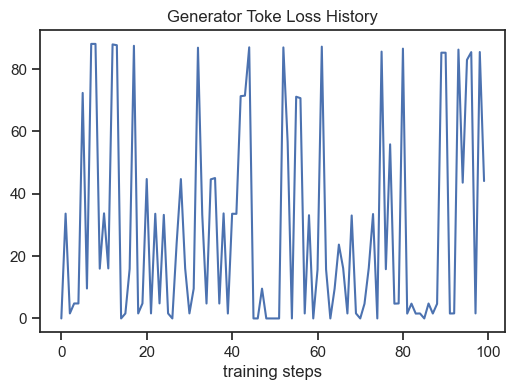

In [32]:
x = range(len(gen_token_loss_history))
plt.figure(dpi=100)
plt.plot(x, gen_token_loss_history)
plt.title('Generator Toke Loss History')
plt.xlabel('training steps')

Text(0.5, 0, 'training steps')

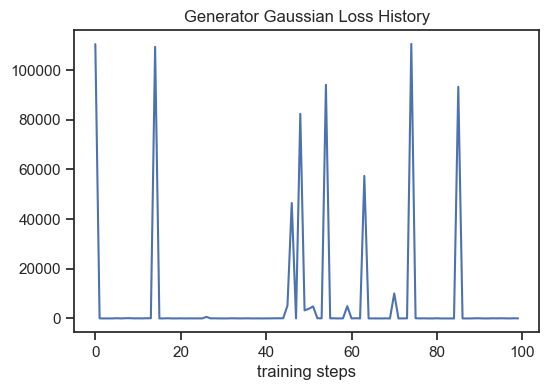

In [33]:
x = range(len(gen_gaussian_loss_history))
plt.figure(dpi=100)
plt.plot(x, gen_gaussian_loss_history)
plt.title('Generator Gaussian Loss History')
plt.xlabel('training steps')

Text(0.5, 0, 'training steps')

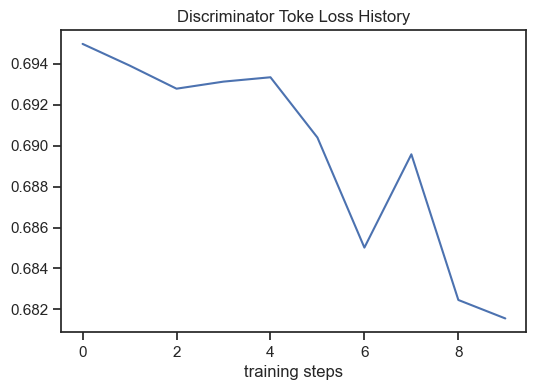

In [34]:
x = range(len(disc_token_loss_history))
plt.figure(dpi=100)
plt.plot(x, disc_token_loss_history)
plt.title('Discriminator Toke Loss History')
plt.xlabel('training steps')

Text(0.5, 0, 'training steps')

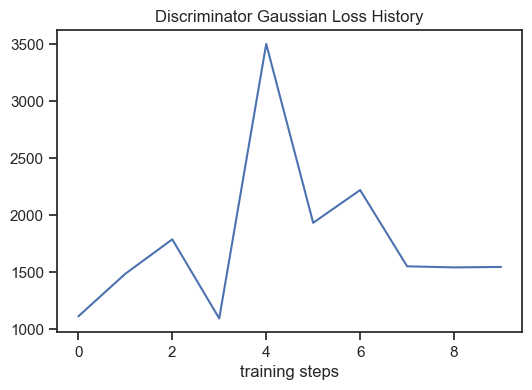

In [35]:
x = range(len(disc_gaussian_loss_history))
plt.figure(dpi=100)
plt.plot(x, disc_gaussian_loss_history)
plt.title('Discriminator Gaussian Loss History')
plt.xlabel('training steps')